### Khaled Sharafaddin

### Image classification using CNNs in Keras

Data Description: 
A dataset of  images of  plant seedlings at various stages of  grown.  Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the projectis to create a classifier capable of determining a plant's species from a photo.

###  1. Import libraries and load dataset

In [1]:
# This allows each cell to output everything instead of just the last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d               # Convolve two 2-dimensional arrays.
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
    

/Users/khaledsharafaddin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/khaledsharafaddin/opt/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
# Load Dataset
img_array = np.load('/Users/khaledsharafaddin/Documents/Univ_Austin_Texas ML_AI/DataSets/images.npy')
img_labels = pd.read_csv('/Users/khaledsharafaddin/Documents/Univ_Austin_Texas ML_AI/DataSets/Labels.csv')

### 2. Print shape of data, visualize the images in dataset

In [3]:
# Shapes: 
print('Shape of images:')
img_array.shape 
print('Labels Shape:')
img_labels.shape  

# Unique Label values:
print('Unique Categories and Count:')
img_labels.Label.unique()
img_labels.Label.value_counts()

# Data Dictionary for Labels:
label_dict =  {0:'Small-flowered Cranesbill', 1:'Fat Hen', 
               2:'Shepherds Purse', 3:'Common wheat', 4:'Common Chickweed'
               , 5:'Charlock', 6:'Cleavers', 
               7:'Scentless Mayweed', 8:'Sugar beet',
               9:'Maize', 10:'Black-grass', 11:'Loose Silky-bent'}



Shape of images:


(4750, 128, 128, 3)

Labels Shape:


(4750, 1)

Unique Categories and Count:


array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

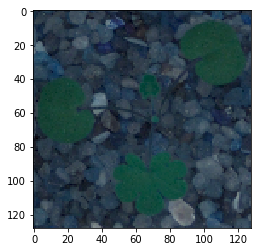

In [4]:
# Visualize the first image
first_image = img_array[1, :, :, :]
plt.imshow(first_image);

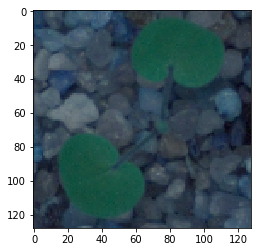

In [5]:
# Visualize another image:
another_img = img_array[112,:,:,:]
plt.imshow(another_img)

### 3. Data Pre-processing

RBG Color Seperation for an image:


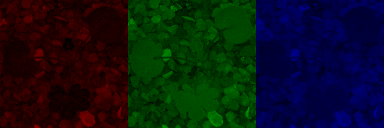

In [6]:
# a. Generation of single color image and concatenation
im_R = first_image.copy()
im_R[:, :, (1, 2)] = 0
im_G = first_image.copy()
im_G[:, :, (0, 2)] = 0
im_B = first_image.copy()
im_B[:, :, (0, 1)] = 0

im_RGB = np.concatenate((im_R, im_G, im_B), axis=1)
pil_img = Image.fromarray(im_RGB)

print('RBG Color Seperation for an image:')
pil_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


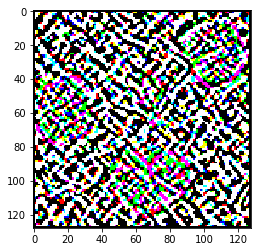

In [7]:
# b. Perform Sobel Operation for Edge Detection for the first image:
# Sharp and thin edges lead to greater efficiency in object recognition. 
sobel = cv2.Sobel(first_image, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

Height=128, width=128


True

Resizing to Small image: 


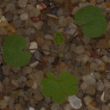

Resizing to Large image: 


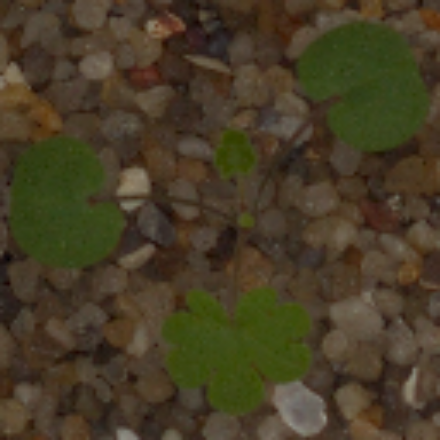

Gray image: 


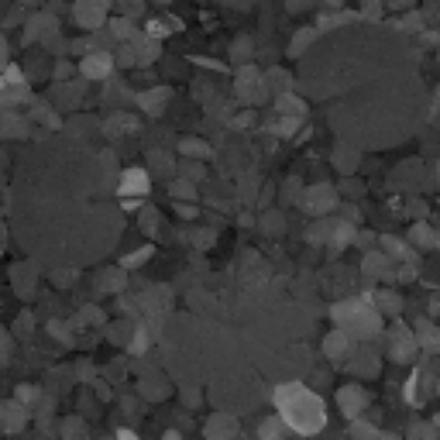

guassian1 Blurring: 


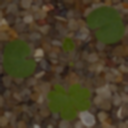

guassian2 Blurring: 


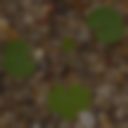

In [8]:
# c. Extract the height and width of the image
h,w = first_image.shape[:2]
print('Height={}, width={}'.format(h,w))


# d. Save image using cs2.imwrite() method
cv2.imwrite('new_image.jpg', first_image)

# Image resizing with OpenCV: 
# resizing is rescaling the image, which helps reduce the num of pixels from an image and that has advantages such as reduce time of training the NN
# The more pixels in an image, the more num of input nodes that in turn increases the complexity of the model
# It also helps with zooming the image
# Many times we need toresize the image to meet size requirements

half = cv2.resize(first_image, (110, 110)) # original was 220 by 220
bigger = cv2.resize(first_image, (440,440))

print('Resizing to Small image: ')
cv2_imshow(half)

print('Resizing to Large image: ')
cv2_imshow(bigger)

# graying the image
gray = cv2.cvtColor(bigger, cv2.COLOR_BGR2GRAY)
print('Gray image: ')
cv2_imshow(gray)

# guassian images: 
guassian1 = cv2.GaussianBlur(first_image, (5,5), 0)
guassian2 = cv2.GaussianBlur(first_image, (15, 15), 0)

print('guassian1 Blurring: ')
cv2_imshow(guassian1)
print('guassian2 Blurring: ')
cv2_imshow(guassian2)

In [9]:
# Normalize Pixel Values : 

from numpy import asarray
from PIL import Image

pixels = asarray(first_image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 0.000, Max: 155.000
Min: 0.000, Max: 0.608


In [10]:
# 4. Split Data into Training and Testing sets:
from sklearn.model_selection import train_test_split
X = img_array
y = img_labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

# Shapes for train, test, and validation sets:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

# Print the label for y_train[0]
print('First Label for y_train: ')
y_train.Label[0]


(3325, 128, 128, 3) (3325, 1)
(712, 128, 128, 3) (712, 1)
(713, 128, 128, 3) (713, 1)
First Label for y_train: 


'Small-flowered Cranesbill'

In [11]:
### 5. Convert labels to one-hot-vectors

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)
y_val = enc.fit_transform(y_val)

# looking at the shapes after transformation
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


# 5. Normalization:
# Conversion to float type from integer type.
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0


(3325, 12)
(712, 12)
(713, 12)


### 4. Building CNN

In [12]:
# 1. Set the batch size, number of epochs.
batch_size = 32
num_classes = 10
epochs = 40
num_predictions = 20

In [13]:
# 2. Building the CNN:

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=x_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [14]:
# 3. Initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 4. Compile the model 
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
# 5. Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=25)


# 6. Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')



### 5. Fit the Model:

In [16]:
# Fit the model with parameters

history = model.fit(x_train,
                    y_train,
                    batch_size=100,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping])


Train on 3325 samples, validate on 712 samples
Epoch 1/50
3325/3325 [==============================] - 255s 77ms/sample - loss: 4.3255 - accuracy: 0.1573 - val_loss: 2.4800 - val_accuracy: 0.0941
Epoch 2/50
3325/3325 [==============================] - 140s 42ms/sample - loss: 2.1397 - accuracy: 0.2809 - val_loss: 2.4830 - val_accuracy: 0.0941
Epoch 3/50
3325/3325 [==============================] - 139s 42ms/sample - loss: 1.8604 - accuracy: 0.3495 - val_loss: 2.5480 - val_accuracy: 0.1376
Epoch 4/50
3325/3325 [==============================] - 139s 42ms/sample - loss: 1.6906 - accuracy: 0.4153 - val_loss: 2.7203 - val_accuracy: 0.1404
Epoch 5/50
3325/3325 [==============================] - 323s 97ms/sample - loss: 1.5206 - accuracy: 0.4565 - val_loss: 3.0176 - val_accuracy: 0.1419
Epoch 6/50
3325/3325 [==============================] - 186s 56ms/sample - loss: 1.4258 - accuracy: 0.5155 - val_loss: 3.2158 - val_accuracy: 0.1419
Epoch 7/50
3325/3325 [==============================] - 139

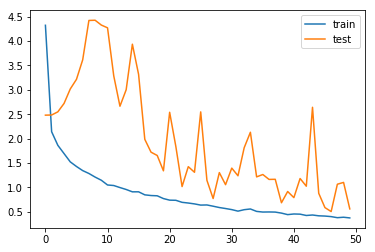

In [17]:
# plot training history and test
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
# Evaluate the training, testing and validation sets on the model:

train_scores = model.evaluate(x_train, y_train, verbose=1)
print('train loss:', train_scores[0])   # train loss: 0.4453092268714331
print('Train accuracy:', train_scores[1]) # Train accuracy: 0.88631576

    
test_scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])     #Test loss: 0.5545063450765074
print('Test accuracy:', test_scores[1]) # Test accuracy: 0.83567417

    
val_scores = model.evaluate(x_val, y_val, verbose=1)
print('val_scores loss:', val_scores[0])  #val_scores loss: 0.5656713917328967
print('val_scores accuracy:', val_scores[1])  # val_scores accuracy: 0.84291726


train loss: 0.4453092268714331
Train accuracy: 0.88631576
Test loss: 0.5545063450765074
Test accuracy: 0.83567417
val_scores loss: 0.5656713917328967
val_scores accuracy: 0.84291726


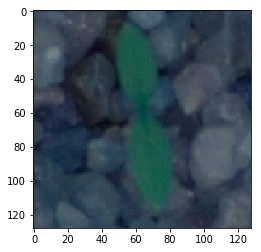

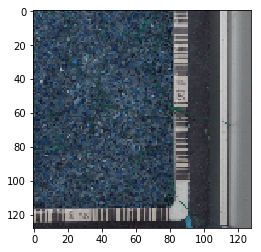

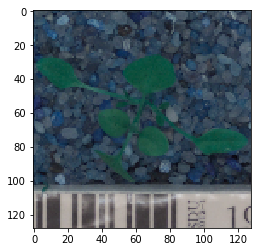

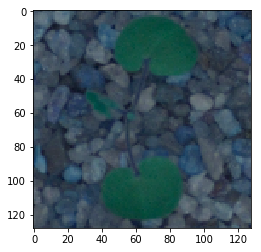

In [28]:
# Visualize some of the samples:
test_list = [x_test[2], x_test[33], x_test[36], x_test[59]]    
for n in test_list:
    arr = np.squeeze(n) 
    plt.imshow(arr)
    plt.show()

### Conclusion:

- CNN model is trained on 3325 sample images of different plant species.
- Batch size of 100 with 50 epochs produced 87% accuracy level on the training dataset. 
- The model is evaluated on a test set and a validation set, giving 83% and 84% accuracy respectively. 
- The model performs pretty well, but it can be imporved by changing some parameters such as the number of epochs and batch size. 